Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(newssummarymore.csv)를 사용하세요.
sunnysai12345/News_Summary

아래의 코드로 데이터를 다운로드 할 수 있어요.
```
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)
```

이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.

Step 2. 데이터 전처리하기 (추상적 요약)

실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해보세요.

Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해보세요.
Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import random
import time

In [2]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)

,headlines,text
38488,2 men posing as cops rob Mumbai woman of gold ...,Two men posing as policemen allegedly robbed a...
41476,"Ram Ram japna, paraya kaam apna: Akhilesh to Yogi",After UP CM Yogi Adityanath inaugurated the 10...
26944,Police find 81 grams of drugs inside US woman'...,Police in the US state of Wisconsin found 81 g...
7019,NCP criticises Maha govt over Ã¢ÂÂ¹500-cr loa...,Nationalist Congress Party has slammed Maharas...
27577,Wedding planner turns Rolls-Royce into carriag...,A wedding planner from Madhya Pradesh's Bhopal...
91621,Countries that invest in education will benefi...,India's Vice President M Hamid Ansari has said...
32126,BJP Karnataka refers to Sonia Gandhi by her bi...,"Taking a dig at Congress leader Sonia Gandhi, ..."
68519,Class 1 student thrashed in Punjab for stammer...,An eight-year-old Class 1 boy at a government ...
11265,Former Congress MP Prem Chand Guddu joins BJP,Former Congress MP and MLA Prem Chand Guddu jo...
11923,"Earlier, PM gave birth to a PM, we changed it:...",Claiming democracy was on the verge of becomin...


In [4]:
data.columns

Index(['headlines', 'text'], dtype='object')

In [5]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [6]:
data['text'].duplicated().sum()

41

In [7]:
data.drop_duplicates(subset = ['text'], inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 98360


In [8]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [9]:
data.text.sample(1)

15075    A 44-year-old woman arrested in West Bengal fo...
Name: text, dtype: object

In [10]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ",len(contractions))

정규화 사전의 수:  120


In [11]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [80]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [81]:
temp_text = "Everything I bought was great, 'cause in fact I ordered twice and the third ordered was<br /> for my mother and father."
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great fact ordered twice third ordered mother father
great way to start the day


In [82]:
if 'in' in eng_stopwords:
    print('yes')

yes


In [83]:
start = time.time()
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
print(f'elasped time: {time.time()-start}')

elasped time: 525.1492238044739


In [84]:
len(clean_text)

98360

In [85]:
type(clean_text)

list

In [86]:
import copy
temp_list = copy.deepcopy(clean_text)

In [87]:
temp_list.extend(data['text'])

In [88]:
pd.DataFrame(temp_list).duplicated().sum()

39

+ 전처리 전 후 동일한 항목이 39개 뿐인 것을 보면 전처리가 잘 된 것 같다.

In [67]:
random.sample(clean_text, 1)

['indian golfer shiv kapur third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april three asian tour titles last eight months kapur first asian tour debut season december']

In [89]:
for i, s in enumerate(clean_text):
    if 'indian golfer shiv kapur' in s:
        print(f'index: {i}, sentence: {s}')

index: 54252, sentence: indian golfer shiv kapur third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april three asian tour titles last eight months kapur first asian tour debut season december


In [90]:
data.text.iloc[54252]

'Indian golfer Shiv Kapur won his third Asian Tour title of 2017 by lifting the Royal Cup in Thailand on Sunday. The 35-year-old golfer, who had just one Asian Tour win till April 2017, has now won three Asian Tour titles in the last eight months. Kapur first won on Asian Tour in his debut season in December 2005.'

In [91]:
data.headlines.iloc[54252]

'Indian golfer Shiv Kapur wins third Asian Tour title of 2017'

In [92]:
if 'won' in stopwords.words('english'):
    print('yes')
else:
    print('no')

yes


+ 축약어 변형 후 won은 win의 과거나 과거분사형 밖에 없으므로 해당 단어는 stopwords에서 제거해 주는 것이 좋겠다. stopwords에 무엇이 들어있는지 확인해 보자

In [93]:
eng_stopwords = stopwords.words('english')

In [94]:
len(eng_stopwords)

179

In [98]:
for t in eng_stopwords:
    print(t, end= ', ')

i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, must

+ 축약어를 풀어낸 후에 stopwords를 제거하는 작업을 할 것이므로 stopwords에서 won만 제거해 주면 될 것 같다.

In [99]:
eng_stopwords.remove('won')

In [100]:
if 'won' in eng_stopwords:
    print('yes')
else:
    print('no')

no


In [101]:
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in eng_stopwords if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [102]:
start = time.time()
clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))
print(f'elasped time: {time.time()-start}')

elasped time: 30.233577251434326


In [103]:
print(clean_text[54252])

indian golfer shiv kapur won third asian tour title lifting royal cup thailand sunday year old golfer one asian tour win till april won three asian tour titles last eight months kapur first won asian tour debut season december


+ 전처리가 잘 된것 같다. stpowords.words('englis')를 직접 반복분에 넣어서 활용하는 것 보다 별도 object로 받아와서 실행하니 전처리도 더 빨리 진행 되었다.

In [105]:
start = time.time()
clean_headline = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headline.append(preprocess_sentence(s, False))
print(f'elasped time: {time.time()-start}')    

elasped time: 17.48799443244934


In [106]:
random.sample(clean_headline, 1)

['boko haram kidnapped schoolgirls by accident reports']

In [108]:
for i, s in enumerate(clean_headline):
    if 'boko haram kidnapped' in s:
        print(f'index: {i}, sentence: {s}')

index: 74841, sentence: boko haram kidnapped schoolgirls by accident reports


In [109]:
data.headlines.iloc[74841]

'Boko Haram kidnapped 200 schoolgirls by accident: Reports'

+ 숫자는 없어도 요약 뜻을 보는데에는 큰 문제 없을 것 같다.

In [112]:
data['text'] = clean_text
data['headlines'] = clean_headline

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [114]:
data.head(2)

,headlines,text
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...


In [115]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [116]:
csv_path = os.getenv('HOME')+'/aiffel/news_summarization/data/preprocessed_news.csv'
data.to_csv(csv_path,index=False)

+ 나중을 위해서 csv는 저장을 해두도록 한다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.12512200081334
텍스트 길이 표준편차 : 3.8047282332638988
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534
헤드라인 길이 표준편차 : 1.3900944321771693


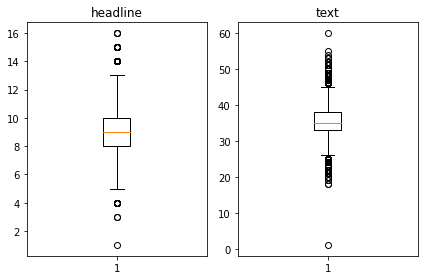

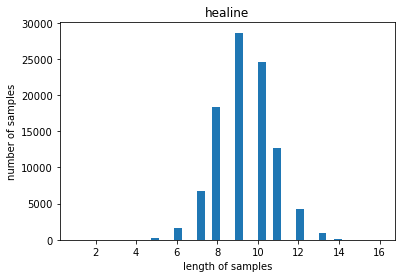

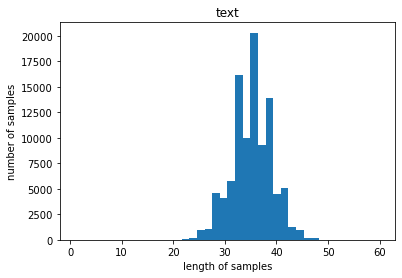

In [202]:
text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print(f'텍스트 길이 표준편차 : {np.std(text_len)}')
print('헤드라인의 최소 길이 : {}'.format(np.min(summary_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(summary_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(summary_len)))
print(f'헤드라인 길이 표준편차 : {np.std(summary_len)}')

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('headline')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('text')
plt.tight_layout()
plt.show()

plt.title('healine')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [203]:
for i, s in enumerate(text_len):
    if s == 1:
        print(f'index: {i}, text: {data.text.iloc[i]}, headline: {data.headlines.iloc[i]}')

index: 52, text: text, headline: headlines


In [204]:
sorted(pd.Series(text_len).unique())[0:3]

[1, 18, 19]

In [205]:
sorted(pd.Series(summary_len).unique())[0:3]

[1, 3, 4]

In [206]:
for i, s in enumerate(summary_len):
    if s < 5:
        print(f'index: {i},headline: {data.headlines.iloc[i]}')

index: 52,headline: headlines
index: 729,headline: angola decriminalises homosexuality
index: 26211,headline: what is friggatriskaidekaphobia
index: 42036,headline: twitter bans cryptocurrency advertisements
index: 42294,headline: intelligence bureau transfers officers
index: 46615,headline: transferred employees not pnb
index: 48287,headline: mirinda launches releasethepressure campaign
index: 49718,headline: cabinet approves union budget
index: 52838,headline: lendingkart finance raises million
index: 55175,headline: infosys completes crore buyback
index: 57420,headline: marijuana wreath being sold
index: 58671,headline: currency note completes years
index: 59665,headline: why is thanksgiving celebrated
index: 78594,headline: karnataka education officers transferred
index: 92550,headline: htc teases squeezable smartphone
index: 93866,headline: pulitzer prize winners announced
index: 96647,headline: in pictures earth hour


+ 짧은 쪽에서는 길이가 1인 데이터만 잘라내면 될 것 같다.

In [207]:
text_max_len = 40
headline_max_len = 13

In [208]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, ( (cnt-1) / len(nested_list))))

In [209]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92254981699878
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981598210654737


In [210]:
cnt = 0
for i in range(len(data)):
    if len(data.text.iloc[i].split()) <= text_max_len and len(data.headlines.iloc[i].split()) <= headline_max_len:
        cnt = cnt+1
print(f'전체 데이터 중 길이 기준 이하 샘플 비율: {(cnt-1) / len(data)}')

전체 데이터 중 길이 기준 이하 샘플 비율: 0.9208011386742578


In [211]:
cnt

90571

In [212]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len and len(x.split()) != 1)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 90570


In [214]:
#요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['text'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken saurav kant alumnus upgrad iiit pg pr...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand defeated india wickets fo...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan custo...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken speaking sexual harassment allegation...,have known hirani for yrs what if metoo claims...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken pakistani singer rahat fateh ali khan...,rahat fateh ali khan denies getting notice for...


In [215]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [216]:
encoder_input.shape

(90570,)

In [217]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[85078 20602 47196 ... 76451 22577 46507]


In [218]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [219]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 18114


In [220]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 72456
훈련 레이블의 개수 : 72456
테스트 데이터의 개수 : 18114
테스트 레이블의 개수 : 18114


In [221]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [222]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65768
등장 빈도가 6번 이하인 희귀 단어의 수: 44756
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 21012
단어 집합에서 희귀 단어의 비율: 68.05133195475003
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.6412544941114398


In [223]:
tar_vocab = 21000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 935, 4048, 196, 968, 3995, 1067, 4048, 22, 121, 3883, 4889, 5735, 3374, 935, 291, 438, 3995, 2046, 1245, 4048, 10284, 1002, 397, 11318, 2462, 842, 3, 935], [1, 876, 167, 231, 1210, 873, 1235, 148, 3, 2283, 263, 473, 1235, 3800, 286, 886, 2567, 1284, 45, 9, 231, 682, 106, 341, 1828, 183, 14216, 219], [1, 294, 639, 1059, 3, 14666, 562, 1799, 824, 3824, 29, 1135, 248, 4710, 13811, 460, 2563, 1311, 1378, 417, 179, 1567, 1843, 4244, 776, 15688, 4095, 1059, 9, 49, 9335, 270, 1311, 11, 417, 363, 14, 29, 4022], [1, 3779, 41, 3375, 1859, 2041, 123, 575, 1974, 63, 116, 708, 3085, 1840, 2041, 1241, 493, 16948, 1974, 1361, 187, 251, 755, 1520, 42, 3288, 1174, 11319, 281, 1974, 2041, 1052, 6, 6726, 11319, 930], [1, 140, 86, 106, 1673, 23, 783, 1070, 166, 125, 540, 23, 6044, 783, 4023, 1673, 5067, 6869, 311, 2188, 5481, 493, 1871, 247, 23, 783, 140, 9, 203, 129, 605, 4166, 10285, 114, 1061, 1003, 9482, 1568]]
target
decoder  [[3995, 1755, 84, 4889, 1705, 10, 121, 2], [2283, 186, 26

In [224]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 72456
훈련 레이블의 개수 : 72456
테스트 데이터의 개수 : 18114
테스트 레이블의 개수 : 18114


In [226]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headline_max_len, padding='post')

ValueError: invalid literal for int() with base 10: 'ly well behaved actually full said owner'

In [233]:
e_i_tr_len = [len(s.split()) for s in encoder_input_train]
e_i_te_len = [len(s.split()) for s in encoder_input_test]
d_i_tr_len = [len(s.split()) for s in decoder_input_train]

AttributeError: 'list' object has no attribute 'split'